In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_96002/3546024755.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('/Users/sachacollinson/Downloads/fake_transactional_data_24.csv')
df = df.rename(columns={"from_totally_fake_account": "AccountNumber", "monopoly_money_amount": "MoneyTransferAmount", "to_randomly_generated_account": "TransferredLocationAccount", "not_happened_yet_date": "TransactionDate"})
# from_totally_fake_account  = AccountNumber
# monopoly_money_amount = MoneyTransferAmount
# to_randomly_generated_account = TransferredLocationAccount
# not_happened_yet_date = TransactionDate
df_NonNumeric_Mapping = pd.read_excel('/Users/sachacollinson/Downloads/Location_value_pairs.xlsx')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format="%d/%m/%Y").dt.date
df = df.sort_values(by=['TransactionDate'])

df_Transferred_numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric())].copy()
df_Transferred_Non_Numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric()==False)].copy()

In [3]:
df_NonNumeric_Mapping['Key'] = df_NonNumeric_Mapping['Key'].str.strip()
mapping_dict = df_NonNumeric_Mapping.to_dict(orient='records')
mapped_dict = {entry['Key']: entry['Value'] for entry in mapping_dict}

# # Create a new column by mapping values from the 'key' column using the mapping dictionary
df_Transferred_Non_Numeric['CategoryTransferredLocationAccount'] = df_Transferred_Non_Numeric['TransferredLocationAccount'].map(mapped_dict)

# # Print the DataFrame with the new column
print(len(df_Transferred_numeric))
print(len(df_Transferred_Non_Numeric))
print(len(df))

frames = [df_Transferred_Non_Numeric,df_Transferred_numeric]
df2 = pd.concat(frames)
df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)
print(df2)

2532763
7615517
10148280
          AccountNumber  MoneyTransferAmount TransferredLocationAccount  \
0               10371.0                 4.00                     CINEMA   
13385           98994.0                 2.65                COFFEE_SHOP   
13384           98994.0                 2.20        A_LOCAL_COFFEE_SHOP   
13383           34189.0                14.50                        BAR   
13382           86417.0                 4.35                COFFEE_SHOP   
...                 ...                  ...                        ...   
10137320        41950.0                 6.00                      21887   
10137322         8097.0                 5.00                      84802   
10137336        99012.0                 6.50                      27845   
10137340        60186.0                 2.65                      35802   
10137248        42065.0                 6.00                      83201   

         TransactionDate CategoryTransferredLocationAccount  
0           

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_96002/3330740510.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)


In [4]:
# Ensure TransactionDate is in datetime format
df2['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)  # Adjusting for day-first format
end_date = pd.Timestamp('2025-12-31')

# RFM Calculation
rfm = df2.groupby('AccountNumber').agg({
    'AccountNumber': 'count',
    'MoneyTransferAmount': 'sum'
}).rename(columns={'AccountNumber': 'Frequency',
                   'MoneyTransferAmount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
rfm['M_Score'] = rfm['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
rfm['RFM_Score'] =  rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the final RFM segmentation
print(rfm.head())

               Frequency  MonetaryValue  F_Score  M_Score RFM_Score
AccountNumber                                                      
1000.0              1710       28698.51        1        3        13
1002.0              1043       15622.97        3        1        31
1006.0              1841       18778.19        1        2        12
1018.0               805       15612.21        4        1        41
1053.0              1319       19444.57        2        2        22


In [5]:
rfm.describe()

,Frequency,MonetaryValue,F_Score,M_Score
count,8142.000000,8142.000000,8142.000000,8142.000000
mean,1246.411201,22925.845676,2.501474,2.500000
std,346.909076,6811.697500,1.118212,1.118213
min,436.000000,8079.130000,1.000000,1.000000
25%,989.000000,17699.610000,2.000000,1.250000
50%,1154.000000,21021.590000,3.000000,2.500000
75%,1500.000000,28918.547500,4.000000,3.750000
max,2728.000000,45141.370000,4.000000,4.000000


In [6]:
# Count the number of customers in each segment
rfm_count = rfm['RFM_Score'].value_counts().reset_index()
rfm_count.columns = ['RFM_Score', 'Count']

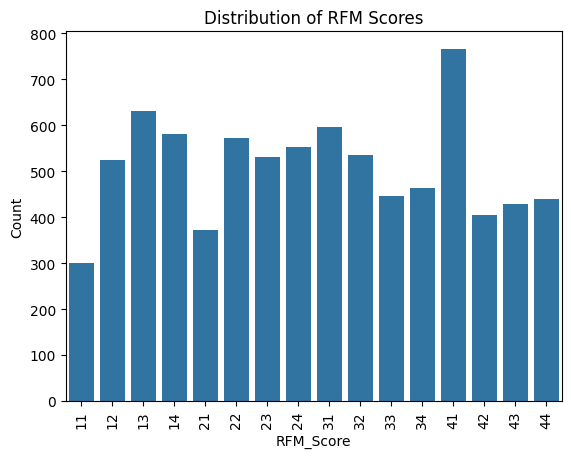

In [7]:
# Plotting the distribution of customers across RFM scores
sns.barplot(x='RFM_Score', y='Count', data=rfm_count.sort_values('RFM_Score'))
plt.title('Distribution of RFM Scores')
plt.xticks(rotation=90)  # Rotates labels to make them readable
plt.show()

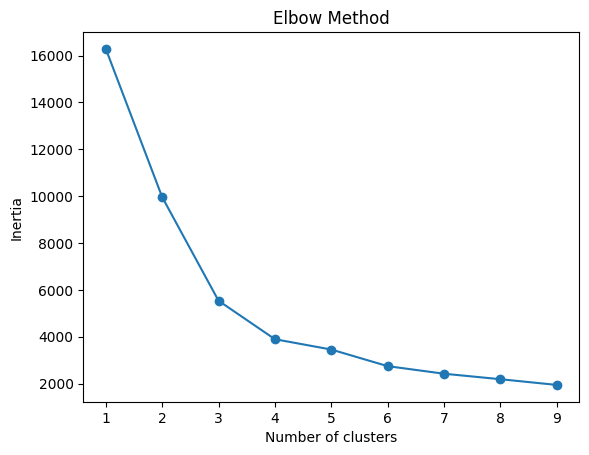

In [8]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[[ 'Frequency', 'MonetaryValue']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'MonetaryValue'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(rfm['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = rfm[rfm['Cluster'] == cluster]
    print(cluster_data.describe())

     Frequency  MonetaryValue
0  1055.851506   18047.325828
1  1120.968978   31270.956966
2  1727.347950   23163.965076

Cluster 0 Characteristics:
         Frequency  MonetaryValue      F_Score      M_Score  Cluster
count  3849.000000    3849.000000  3849.000000  3849.000000   3849.0
mean   1056.068849   18039.262240     3.069109     1.731099      0.0
std     172.716412    3102.655719     0.799496     0.746560      0.0
min     513.000000    8079.130000     1.000000     1.000000      0.0
25%     944.000000   15906.790000     2.000000     1.000000      0.0
50%    1059.000000   18050.430000     3.000000     2.000000      0.0
75%    1174.000000   20224.690000     4.000000     2.000000      0.0
max    1558.000000   25311.210000     4.000000     3.000000      0.0

Cluster 1 Characteristics:
         Frequency  MonetaryValue      F_Score      M_Score  Cluster
count  2190.000000    2190.000000  2190.000000  2190.000000   2190.0
mean   1119.265297   31253.871749     2.831507     3.743836      

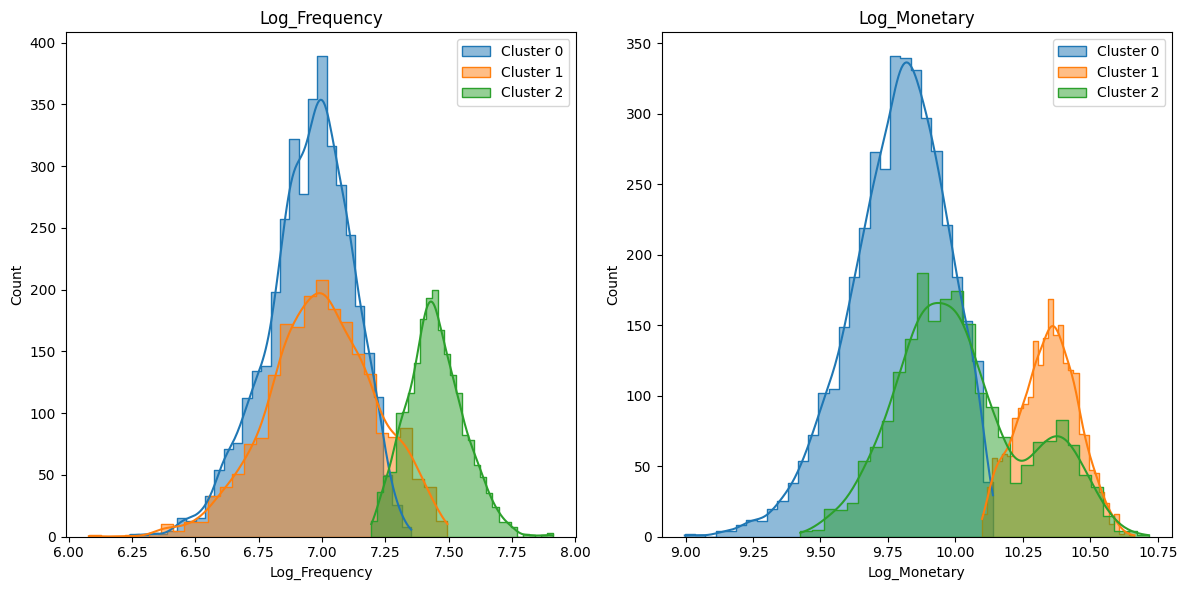

In [10]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['MonetaryValue'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

features = [ 'Log_Frequency', 'Log_Monetary']
for i, feature in enumerate(features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(rfm[rfm['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

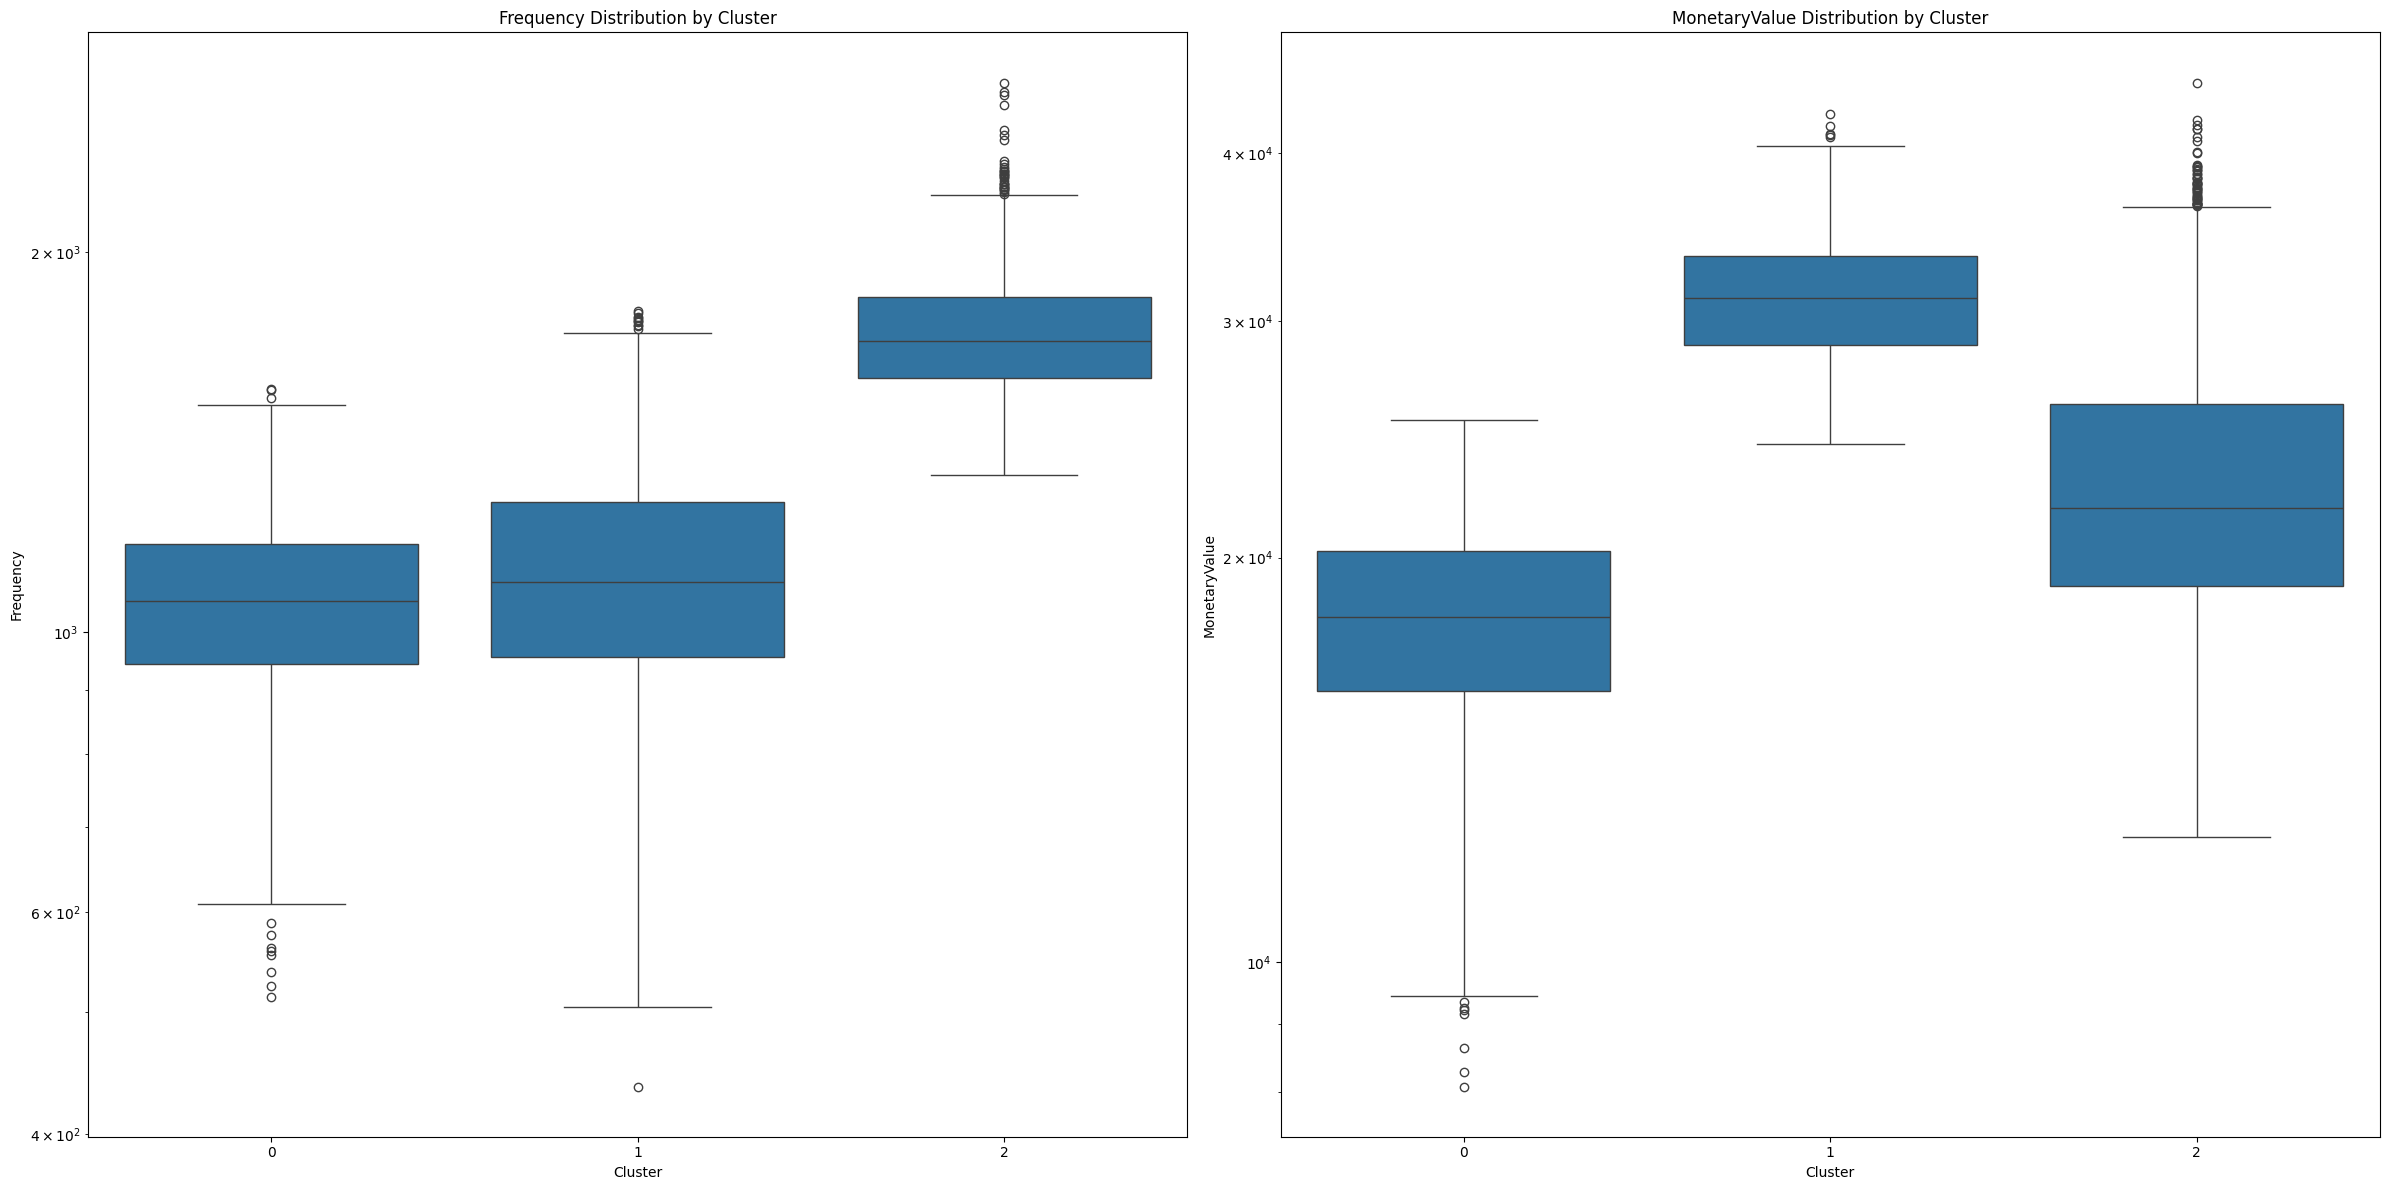

In [11]:
features = ['Frequency', 'MonetaryValue']
fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Adjust the size as needed

for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=rfm, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Cluster')
    # Optional: To improve readability, you might log-transform Frequency and Monetary values
    if feature in ['Frequency', 'MonetaryValue']:
        axes[i].set_yscale('log')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [12]:
merged_df = pd.merge(df2, rfm, on='AccountNumber', how='left')

print(merged_df)

          AccountNumber  MoneyTransferAmount TransferredLocationAccount  \
0               10371.0                 4.00                     CINEMA   
1               98994.0                 2.65                COFFEE_SHOP   
2               98994.0                 2.20        A_LOCAL_COFFEE_SHOP   
3               34189.0                14.50                        BAR   
4               86417.0                 4.35                COFFEE_SHOP   
...                 ...                  ...                        ...   
10148275        41950.0                 6.00                      21887   
10148276         8097.0                 5.00                      84802   
10148277        99012.0                 6.50                      27845   
10148278        60186.0                 2.65                      35802   
10148279        42065.0                 6.00                      83201   

         TransactionDate CategoryTransferredLocationAccount  Frequency  \
0             2025-01-01 

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_96002/738185343.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_96002/738185343.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_monetary_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_96002/738185343.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_9

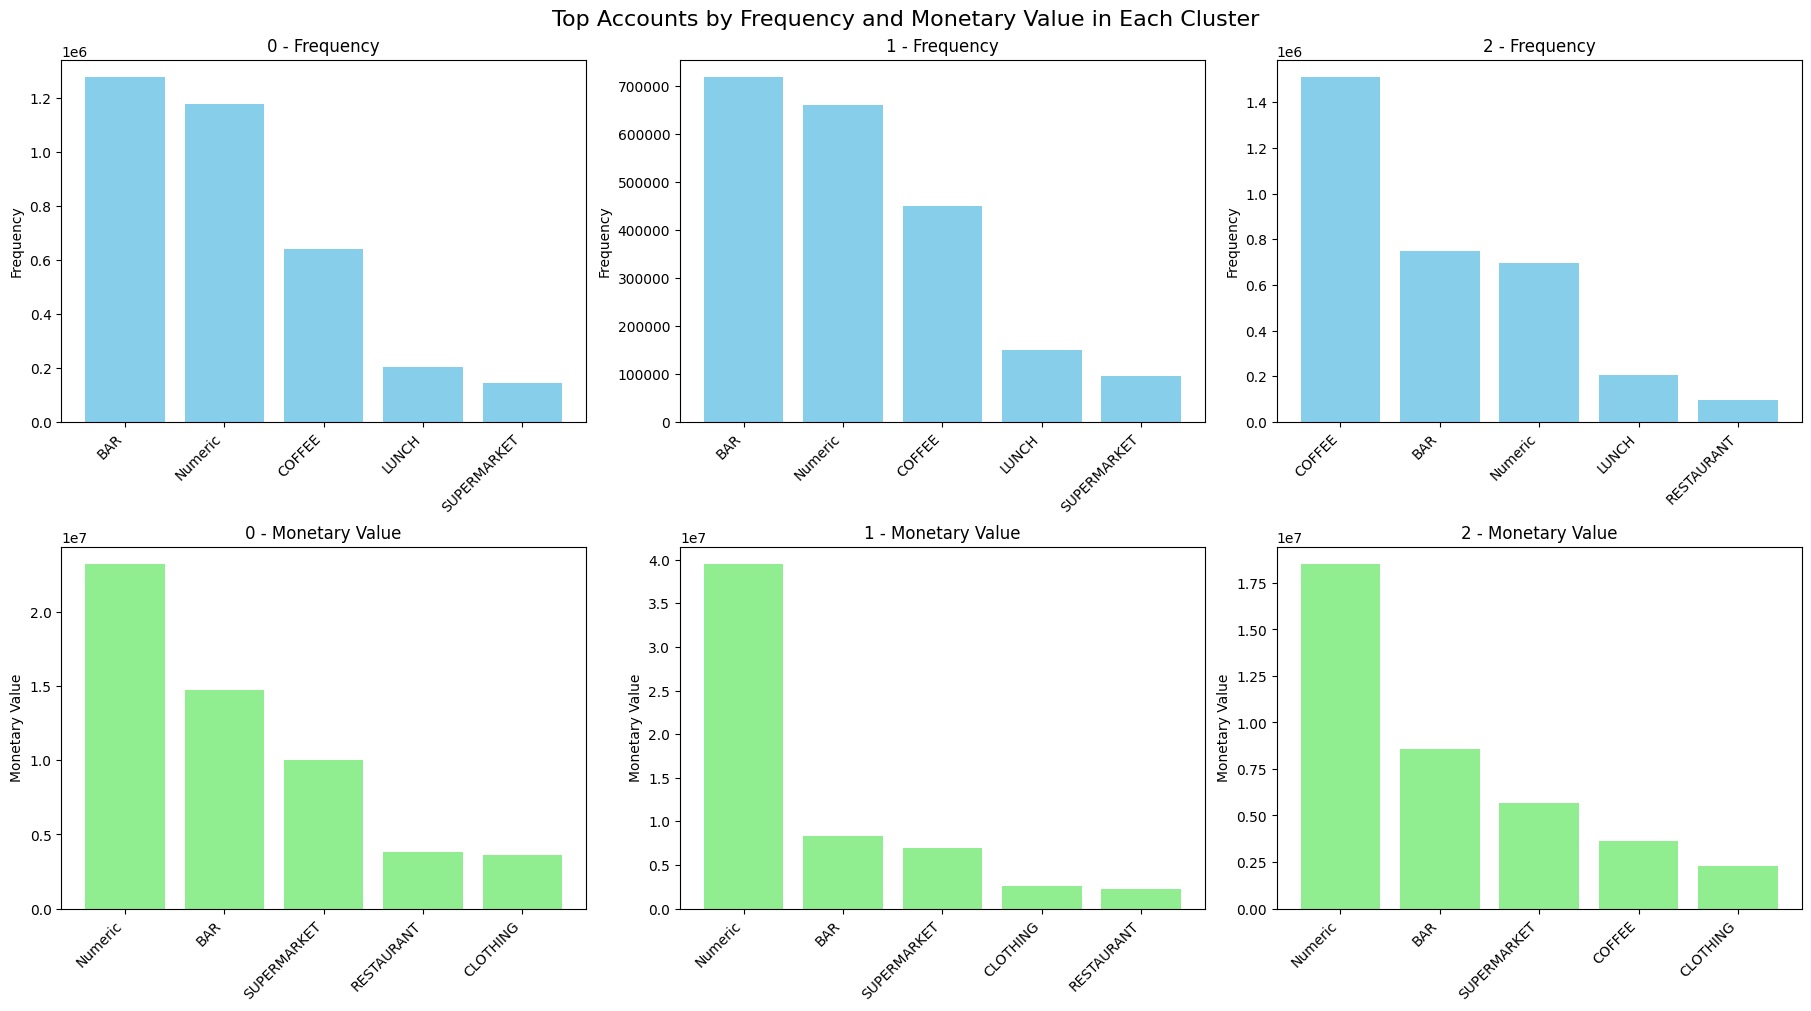

In [13]:
# Aggregating data for frequency and monetary value by cluster and account
frequency_df = merged_df.groupby(['Cluster', 'CategoryTransferredLocationAccount']).size().reset_index(name='Frequency')
monetary_df = merged_df.groupby(['Cluster', 'CategoryTransferredLocationAccount'])['MoneyTransferAmount'].sum().reset_index(name='MonetaryValue')

# Sorting for top accounts in each cluster by frequency
top_frequency_df = frequency_df.sort_values(by=['Cluster', 'Frequency'], ascending=[True, False]).groupby('Cluster').head(5)

# Sorting for top accounts in each cluster by monetary value
top_monetary_df = monetary_df.sort_values(by=['Cluster', 'MonetaryValue'], ascending=[True, False]).groupby('Cluster').head(5)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), constrained_layout=True)
fig.suptitle('Top Accounts by Frequency and Monetary Value in Each Cluster', fontsize=16)

clusters = merged_df['Cluster'].unique()
for i, cluster in enumerate(sorted(clusters)):
    # Frequency
    ax = axes[0, i]
    top_freq_cluster = top_frequency_df[top_frequency_df['Cluster'] == cluster]
    ax.bar(top_freq_cluster['CategoryTransferredLocationAccount'], top_freq_cluster['Frequency'], color='skyblue')
    ax.set_title(f'{cluster} - Frequency')
    ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
    ax.set_ylabel('Frequency')

    # Monetary Value
    ax = axes[1, i]
    top_monetary_cluster = top_monetary_df[top_monetary_df['Cluster'] == cluster]
    ax.bar(top_monetary_cluster['CategoryTransferredLocationAccount'], top_monetary_cluster['MonetaryValue'], color='lightgreen')
    ax.set_title(f'{cluster} - Monetary Value')
    ax.set_xticklabels(top_monetary_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
    ax.set_ylabel('Monetary Value')

plt.show()

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import numpy as np

# Define the adapted k-fold cross-validation function for clustering
def clustering_k_fold_cross_validation(data, num_clusters, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    silhouette_scores = []

    for train_index, test_index in kf.split(data):
        # Split data into training and testing sets
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        # Apply KMeans clustering to the training data
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(train_data)

        # Assign clusters to test data based on nearest centroids
        test_labels = kmeans.predict(test_data)

        # Calculate silhouette score for the test data
        score = silhouette_score(test_data, test_labels)
        silhouette_scores.append(score)

    # Calculate average silhouette score across all folds
    average_silhouette_score = np.mean(silhouette_scores)
    return silhouette_scores, average_silhouette_score

# Note: We will need to preprocess your dataset similar to what you did in your notebook to apply this function.
# For now, I'll create a dummy dataset to demonstrate how the function works.
# Replace this with your actual data and preprocessing steps.

# Dummy dataset for demonstration

dummy_data = rfm  # Replace this with your preprocessed RFM data

# Perform the adapted k-fold validation for clustering
# Adjust the number of clusters based on your elbow method result
silhouette_scores, average_silhouette_score = clustering_k_fold_cross_validation(dummy_data, num_clusters=3, k=5)
silhouette_scores, average_silhouette_score

([0.5596530568111229,
  0.5492018062758027,
  0.548527122183061,
  0.5618834174645159,
  0.5567480719916509],
 0.5552026949452307)

## DBSCAN

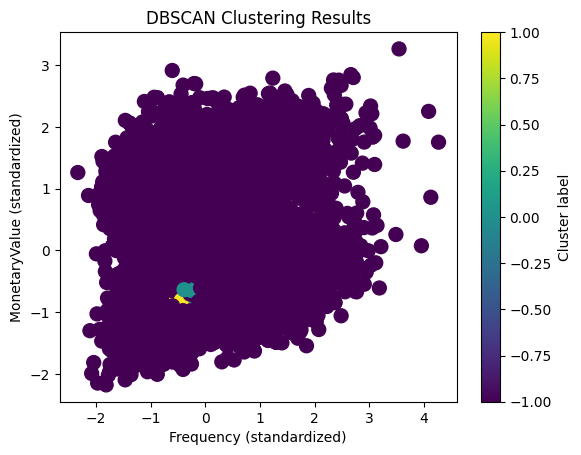

In [49]:
# 1. Import necessary libraries
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# RFM Calculation
dbs = df2.groupby('AccountNumber').agg({
    'AccountNumber': 'count',
    'MoneyTransferAmount': 'sum'
}).rename(columns={'AccountNumber': 'Frequency',
                   'MoneyTransferAmount': 'MonetaryValue'})
# Removed the line that sets 'AccountNumber' as index since it's already the index

# Selecting only 'Frequency' and 'MonetaryValue' for clustering
X = dbs[['Frequency', 'MonetaryValue']].values  # This should now work correctly

# Standardizing the data
X_scaled = StandardScaler().fit_transform(X)

# 3. Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.08, min_samples=70).fit(X_scaled)  # Adjust eps and min_samples as needed
labels = dbscan.labels_

# 4. Visualize the results
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', marker='o', s=100)  # Color points by cluster label
plt.xlabel('Frequency (standardized)')
plt.ylabel('MonetaryValue (standardized)')
plt.title('DBSCAN Clustering Results')
plt.colorbar(label='Cluster label')
plt.show()


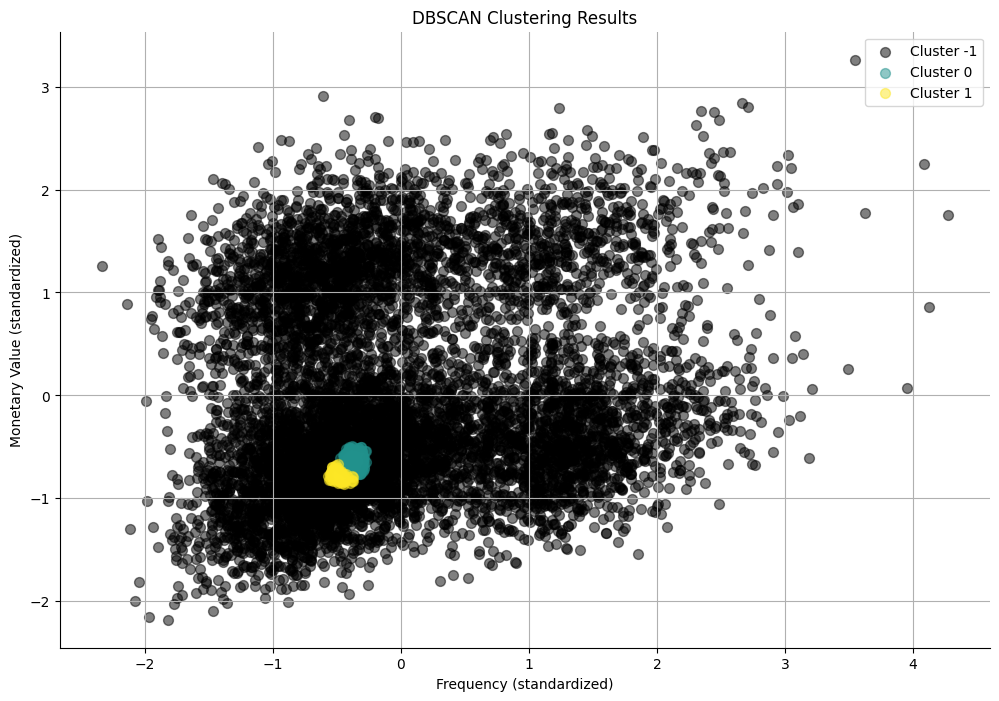

In [50]:
# 4. Visualize the results with improvements
plt.figure(figsize=(12, 8))  # Set a larger figure size for better readability
unique_labels = np.unique(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, col in zip(unique_labels, colors):
    if label == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == label)

    xy = X_scaled[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], alpha=0.5, label=f'Cluster {label}')  # Adjust alpha for transparency

# Customize the plot
plt.xlabel('Frequency (standardized)')
plt.ylabel('Monetary Value (standardized)')
plt.title('DBSCAN Clustering Results')
plt.legend(loc='best')  # Add a legend to identify clusters
plt.grid(True)  # Add a grid
# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [30]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, labels)
print('Silhouette Score: %.2f' % score)

Silhouette Score: -0.52


In [31]:
# Assuming 'df' is your original DataFrame with 'labels' from DBSCAN
dbs['Cluster'] = labels
cluster_profile = dbs.groupby('Cluster').mean()
print(cluster_profile)

           Frequency  MonetaryValue
Cluster                            
-1       1611.240964   27091.763735
 0       1222.956729   22538.385211
 1       1973.200000   32811.540000
 2        751.857143   33356.732857
 3       1372.875000   14444.411250
...              ...            ...
 59       670.333333   23171.230000
 60      2042.666667   33023.823333
 61      1890.000000   37596.186667
 62       807.666667   35877.673333
 63      1498.666667   39836.980000

[65 rows x 2 columns]


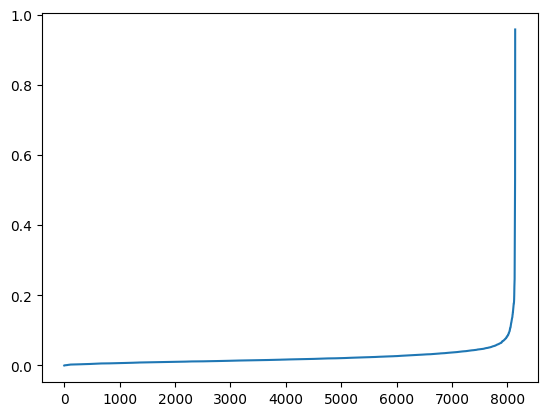

In [22]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]  # Change to 1 since we're interested in the second nearest point
plt.plot(distances)
plt.show()

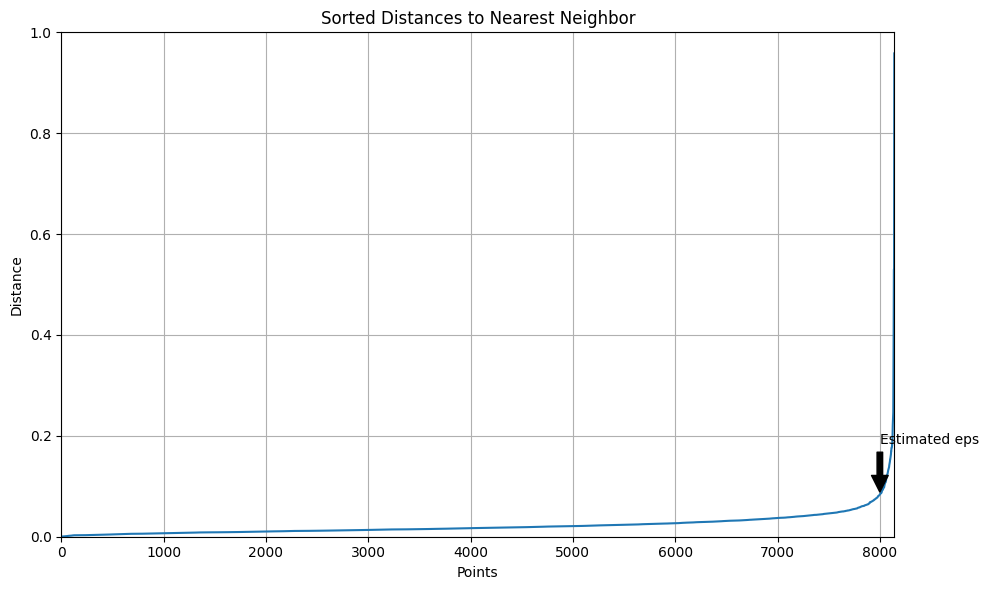

In [26]:
import matplotlib.pyplot as plt

# Assuming 'distances' contains the sorted distances to the nearest neighbor
plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(distances)
plt.title('Sorted Distances to Nearest Neighbor')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.xlim([0, len(distances)])  # Adjust x-axis limits if necessary
plt.ylim([0, 1])  # Focus on a specific Y-axis range if you know the elbow is within this range
plt.grid(True)  # Add gridlines

# Optional: Annotate the estimated elbow point (you need to define elbow_x and elbow_y based on your data)
elbow_x = 8000  # This is an example; you should find the actual index of the elbow
elbow_y = distances[elbow_x]
plt.annotate('Estimated eps', xy=(elbow_x, elbow_y), xytext=(elbow_x, elbow_y+0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.tight_layout()
plt.show()

In [27]:
print(distances[8000])

0.08372091312985372


 ## HIERACHACAL CLUSTERING

In [52]:
# Calculating frequency and monetary values for each account
# Frequency: Number of transactions per account
frequency = df2.groupby('AccountNumber').size().reset_index(name='Frequency')

# Monetary: Total money transferred per account
monetary = df2.groupby('AccountNumber')['MoneyTransferAmount'].sum().reset_index(name='Monetary')

# Merge frequency and monetary data
fm_table = pd.merge(frequency, monetary, on='AccountNumber')

# Display the FM table
fm_table.head()

,AccountNumber,Frequency,Monetary
0,1000.0,1710,28698.51
1,1002.0,1043,15622.97
2,1006.0,1841,18778.19
3,1018.0,805,15612.21
4,1053.0,1319,19444.57


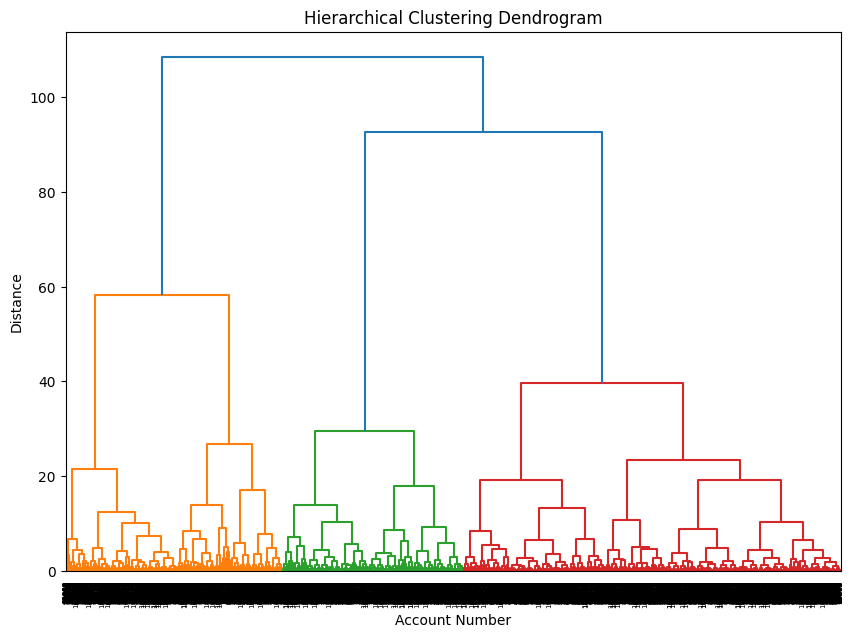

In [53]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
fm_scaled = scaler.fit_transform(fm_table[['Frequency', 'Monetary']])

# Perform hierarchical clustering
Z = linkage(fm_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, labels=fm_table['AccountNumber'].astype(int).astype(str).values)
plt.xlabel('Account Number')
plt.ylabel('Distance')
plt.show()

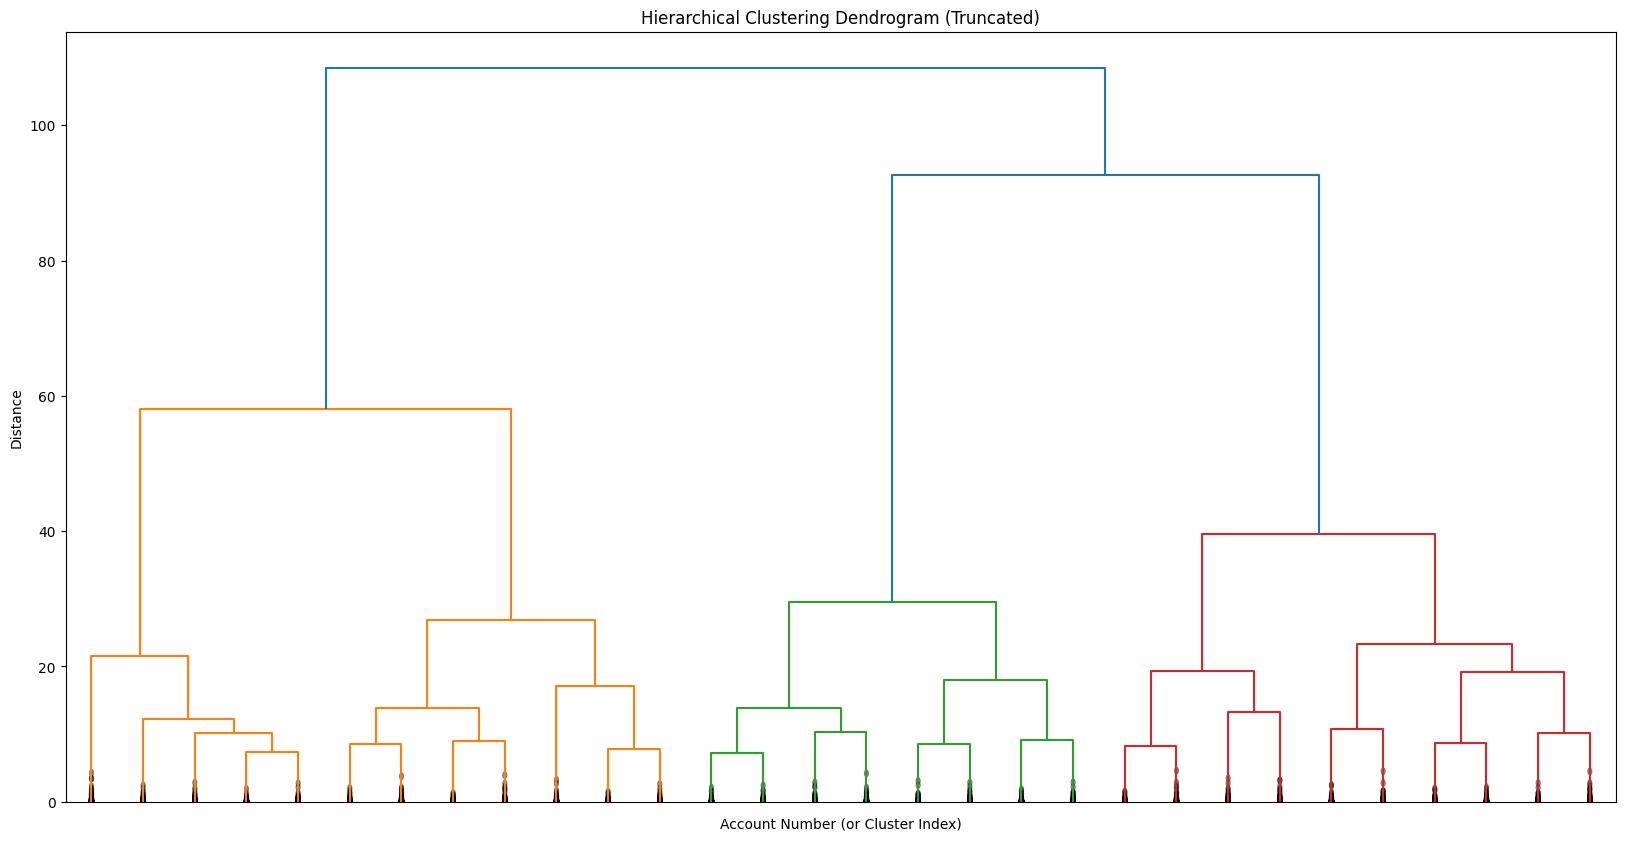

In [54]:
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last 30 merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.xlabel('Account Number (or Cluster Index)')
plt.ylabel('Distance')
plt.show()